# Определение рыночной стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Для оценки качества моделей необходимо использовать метрику RMSE. Значение метрики должно быть меньше 2500.

**Признаки:**

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак:**

- `Price` — цена (евро)

**Краткий план действий:**

1. Загрузка и изучение данных;
2. Предобработка данных, подготовка выборок;
3. Обучение моделей градиентного бустинга и простых моделей;
4. Анализ показателей моделей.
5. Выбор оптимальной модели, проверка на тестовой выборке.

## Загрузка и осмотр данных

In [ ]:
# загружаем необходимы библиотеки и модули
!pip install phik
!pip install optuna
!pip install -U scikit-learn

import pandas as pd
import numpy as np
import phik
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
import lightgbm as lgb
import catboost as cb
import optuna.logging

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyRegressor

In [ ]:
# загружаем данные
df = pd.read_csv('/datasets/autos.csv')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
151575,2016-04-02 16:58:31,7399,wagon,2005,auto,150,e_klasse,150000,0,gasoline,mercedes_benz,no,2016-04-02 00:00:00,0,32549,2016-04-06 16:16:09
116068,2016-03-14 22:58:43,5390,bus,2005,manual,105,touran,150000,6,gasoline,volkswagen,no,2016-03-14 00:00:00,0,1468,2016-03-17 23:15:49
64037,2016-03-28 11:45:28,999,sedan,1996,manual,116,vectra,20000,6,petrol,opel,no,2016-03-28 00:00:00,0,90556,2016-04-06 13:45:55
312098,2016-03-28 10:52:07,4500,NaN,2017,manual,197,clk,125000,11,NaN,mercedes_benz,NaN,2016-03-28 00:00:00,0,12555,2016-04-06 12:45:21
83952,2016-04-03 14:06:23,9500,convertible,2006,manual,116,eos,40000,11,petrol,volkswagen,no,2016-04-03 00:00:00,0,35606,2016-04-04 18:32:42


Размер датасета: 354369 строк, 16 столбцов.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           3543

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


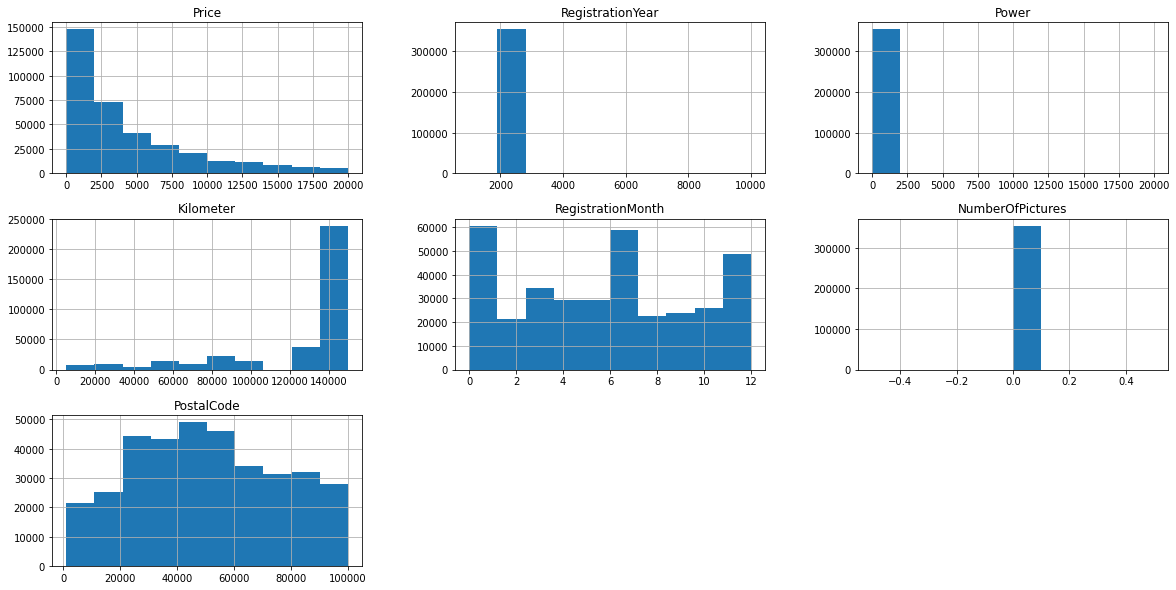

In [ ]:
# изучим сырые данные
display(df.sample(5))
print(f'Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов.')

print('')

df.info(),

display(df.describe())

df.hist(figsize=(20,10));

В данных есть пропуски, визуализируем, чтобы увидеть масштаб проблемы:

In [ ]:
# функция для подсчета пропусков
def pass_value_barh(df):

    fig, ax = plt.subplots(figsize=(19, 6))

    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by='space', ascending=True)
            .plot(kind='barh', figsize=(19,6), legend=False, fontsize=16, ax = ax)

        );

        plt.title('Пропущенные значения, %' + "\n", fontsize=22, color='SteelBlue')
        plt.xlabel('Процент пропусков', fontsize=22)
        plt.ylabel('Столбцы с пропусками', fontsize=22)

        plt.xlim(0, 100)

        for i in ax.patches:
            plt.text(i.get_width()+0.2, i.get_y()+0.1,
                     str(round((i.get_width()), 1)),
                     fontsize=14,
                     color='black')

    except:
        print('пропусков не осталось или произошла ошибка в первой части функции')


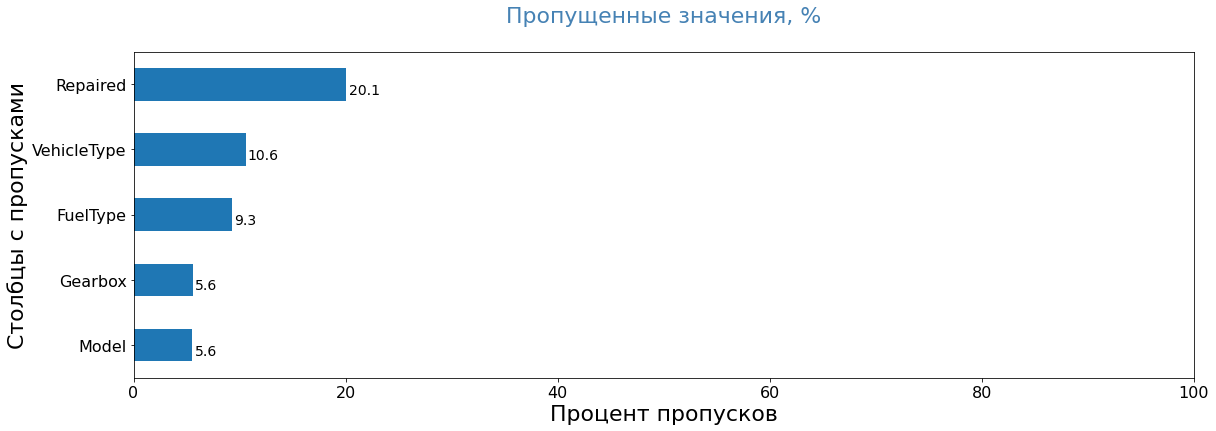

In [ ]:
# визуализируем пропуски
pass_value_barh(df)

Посмотрим, за какой период нам доступны данные:

In [ ]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y%m%d %H:%M:%S')
print(f"Данные доступны за период: {df['DateCreated'].dt.year.min()} - {df['DateCreated'].dt.year.max()} гг.")

Данные доступны за период: 2014 - 2016 гг.


### Вывод

1. В датасете присутствуют неинформативные признаки:
   
   - DateCrawled — дата скачивания анкеты из базы;
   - RegistrationMonth — месяц регистрации автомобиля;
   - DateCreated — дата создания анкеты;
   - NumberOfPictures — количество фотографий автомобиля;
   - PostalCode — почтовый индекс владельца анкеты (пользователя);
   - LastSeen — дата последней активности пользователя.

   Эти данные не нужны для обучении моделей, удалим их.
   

2. Названия столбцов для удобства необходимо привести к "змеиному" регистру.


3. В датасете есть пропуски в категориальных признаках.


4. Присутствуют аномальные значения и выбросы:
   
   - минимальное значение целевого признака `Price` равно 0;
   - диапазон значений в столбце `RegistrationYear` варьируется от 1000 до 9999;
   - минимальная мощность автомобилей - 0, максимальная - 20000.

## Предобработка данных

### Неинформативные признаки

Удалим неинформативные признаки и запишем датасет в новую переменную:

In [ ]:
data = df.copy()
data = data.drop(['DateCrawled',
              'RegistrationMonth',
              'DateCreated',
              'NumberOfPictures',
              'PostalCode',
              'LastSeen'], axis= 1)

### Названия столбцов

Приведем названия столбцов к 'змеиному' регистру:

In [ ]:
data = data.rename(columns={'VehicleType': 'vehicle_type',
                            'RegistrationYear': 'registration_year',
                            'FuelType': 'fuel_type'})
data.columns = data.columns.str.lower()

In [ ]:
print(data.columns)

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')


### Работа с дубликатами

Проверим данные на явные дубликаты:

In [ ]:
print('Количество явных дубликатов:',data.duplicated().sum())
print('Доля дубликатов в общем количестве данных,%:', (data.duplicated().sum() / len(data))*100)

Количество явных дубликатов: 45040
Доля дубликатов в общем количестве данных,%: 12.709915370701161


Явных дубликатов достаточно много, придется удалить на данном этапе почти 13% данных, так как совпадение автомобилей по всем параметрам маловероятно:

In [ ]:
data = data.drop_duplicates().reset_index(drop=True)
print('Количество явных дубликатов после очистки:',data.duplicated().sum())

Количество явных дубликатов после очистки: 0


### Работа с пропусками

Признаки, имеющие пропуски, принадлежат к типу object. Заменим пропущенные значения на "unk", так как восстановить их не представляется возможным:

In [ ]:
data = data.fillna('unk')
print('Количество пропусков:')
data.isna().sum()

Количество пропусков:


price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

### Обработка аномальных значений

#### Цена

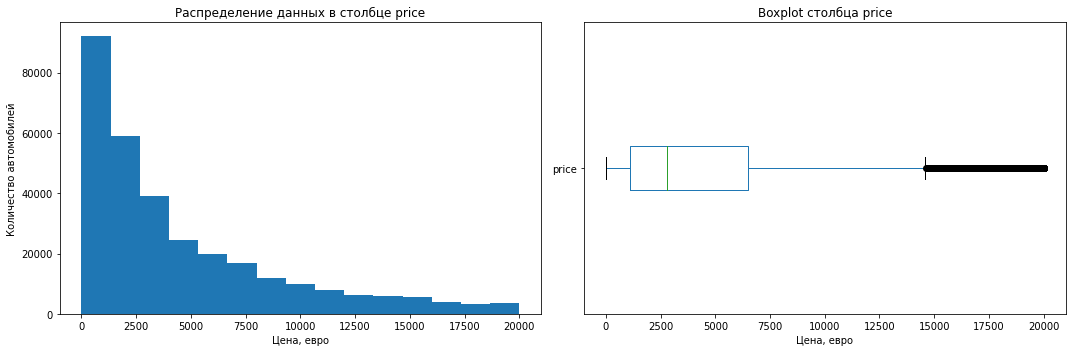

In [ ]:
# визуализируем распределение
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


data['price'].plot(kind='hist',
                   ax = ax1,
                   bins = 15)
ax1.set_title('Распределение данных в столбце price')
ax1.set_xlabel('Цена, евро')
ax1.set_ylabel('Количество автомобилей')


data['price'].plot(kind='box',
                   ax = ax2,
                   vert=False)
ax2.set_title('Boxplot столбцa price')
ax2.set_xlabel('Цена, евро')

plt.tight_layout()
plt.show()

Автомобилей с ценой около нуля достаточно много, они входят в нормальное распределение, а вот автомобили с ценой выше 15 тыс. евро боксплот маркирует как вбросы. Рассмотрим крайние значения подробнее:

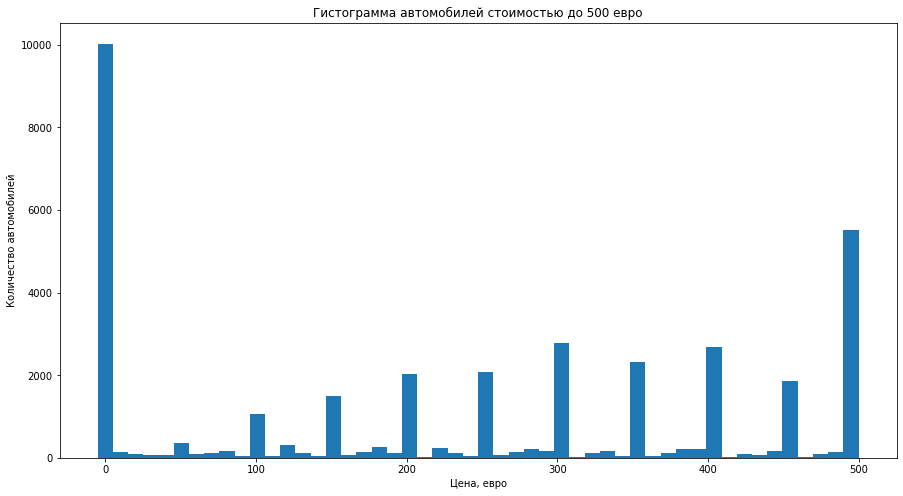

              price  registration_year         power      kilometer
count  11281.000000       11281.000000  11281.000000   11281.000000
mean       6.152291        2011.504033     80.071979  120637.354844
std       19.180406         302.037511    238.767657   51251.161048
min        0.000000        1000.000000      0.000000    5000.000000
25%        0.000000        1996.000000      0.000000  125000.000000
50%        0.000000        2000.000000     67.000000  150000.000000
75%        0.000000        2005.000000    116.000000  150000.000000
max       99.000000        9999.000000  15016.000000  150000.000000


In [ ]:
# гистограмма распределения автомобилей стоимостью до 500 евро
data['price'].plot(kind='hist',
                   range=(-5,500),
                   bins = 50,
                   figsize=(15,8))
plt.title('Гистограмма автомобилей стоимостью до 500 евро')
plt.xlabel('Цена, евро')
plt.ylabel('Количество автомобилей')
plt.show()

print(data.query('price<100').describe())

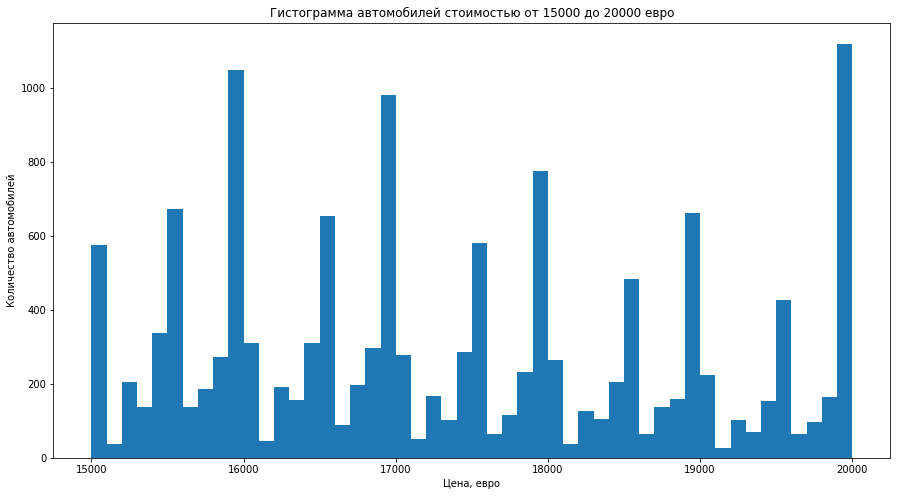

In [ ]:
# гистограмма распределения автомобилей стоимостью от 15000 евро
data['price'].plot(kind='hist',
                   range=(15000,20000),
                   bins = 50,
                   figsize=(15,8))
plt.title('Гистограмма автомобилей стоимостью от 15000 до 20000 евро')
plt.xlabel('Цена, евро')
plt.ylabel('Количество автомобилей')
plt.show()

In [ ]:
print(f'1-й перцентиль равен (не включая объявления, где цена = 0): {np.percentile (data.query("price!=0").price, 1)} евро')

1-й перцентиль равен (не включая объявления, где цена = 0): 100.0 евро


Распределение дорогих автомобилей не выглядит аномальным, а вот цены ниже 500 евро вызывают вопросы, особенно бесплатные автомобили. Скорее всего, такая цена в большинстве объявлений была выставлена для привлечения внимания или повышения объявления в поисковой выдаче, а возможно существует ошибка при формировании данных или их выгрузке. В любом случае предсказывать данную цену не имеет смысла, ограничим начало диапазона целевого признака 500-ми евро:

In [ ]:
data = data.query('price>=500')
print("Минимальная цена в выборке:",data['price'].min())

Минимальная цена в выборке: 500


#### Год регистрации автомобиля

Проанализируем распределение в столбце `registration_year`:

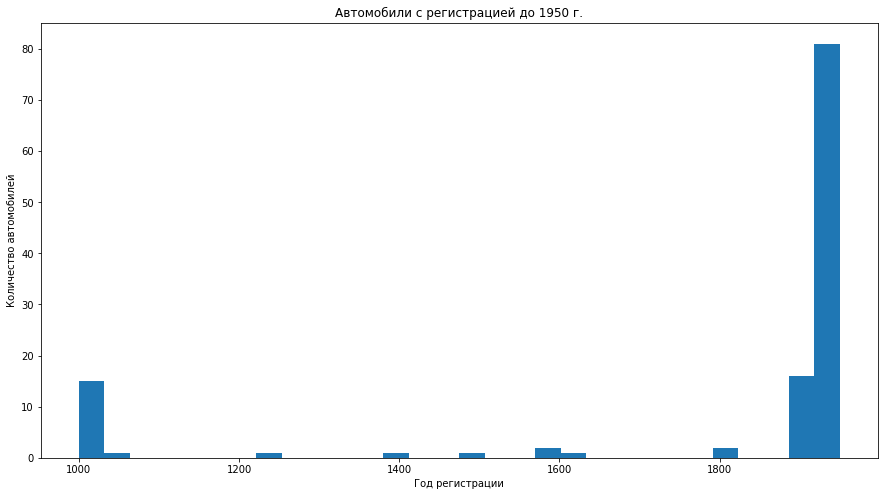

In [ ]:
# гистограмма распределния автомобилей с годом регистрации до 1950
data['registration_year'].plot(kind='hist',
                               range=(1000,1950),
                               bins = 30,
                               figsize=(15,8))
plt.title('Автомобили с регистрацией до 1950 г.')
plt.xlabel('Год регистрации')
plt.ylabel('Количество автомобилей')
plt.show()

Автомобили с регистрацией до 1800 года являются явными аномалиями - скорее всего это пользовательская ошибка или баг. Удалим из выборки эти вбросы:

In [ ]:
data = data.query('registration_year > 1800')
print("Самый ранний год регистрации автомобиля:",data['registration_year'].min())

Самый ранний год регистрации автомобиля: 1910


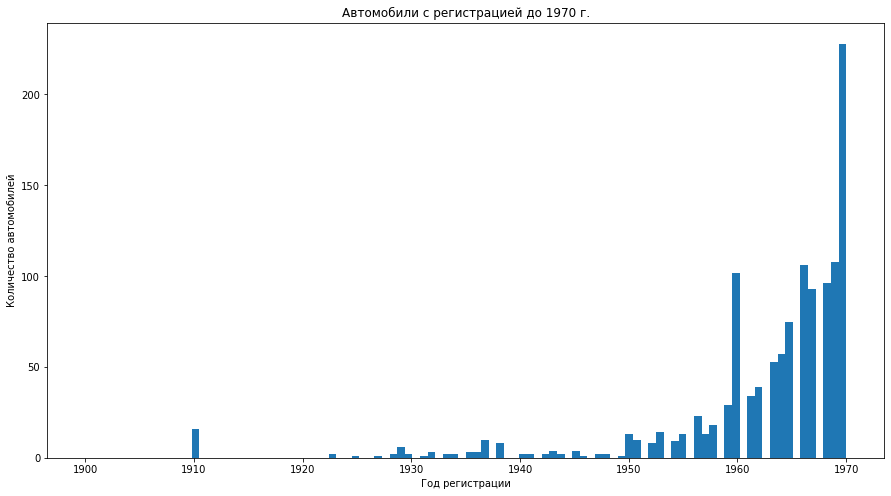

In [ ]:
# гистограмма распределния автомобилей с годом регистрации до 1970
data['registration_year'].plot(kind='hist',
                   range=(1900,1970),
                   bins = 100,
                   figsize=(15,8))
plt.title('Автомобили с регистрацией до 1970 г.')
plt.xlabel('Год регистрации')
plt.ylabel('Количество автомобилей')
plt.show()

In [ ]:
display(data.query('registration_year == 1910'))

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
10110,1250,unk,1910,unk,0,other,5000,unk,audi,unk
23377,3900,wagon,1910,manual,90,passat,150000,petrol,volkswagen,unk
47583,600,small,1910,manual,0,agila,5000,unk,opel,yes
55247,1000,unk,1910,unk,0,unk,150000,unk,sonstige_autos,unk
60658,3400,small,1910,manual,90,beetle,90000,unk,volkswagen,no
79344,500,unk,1910,unk,0,corsa,150000,unk,opel,unk
85933,5000,unk,1910,unk,0,unk,150000,petrol,bmw,unk
110723,599,small,1910,manual,0,unk,5000,petrol,renault,unk
125397,1000,unk,1910,unk,0,unk,5000,unk,sonstige_autos,unk
203667,1500,bus,1910,manual,999,espace,150000,unk,renault,unk


Раритетные автомобили возможно найти в продаже, но в представленной выше выборке это явно не они, большинство параметров автомобилей с багом неизвесты, а те объявления, где модель и марка указаны, свидетельствуют о том, что машины произведены гораздо позже 1910 года. Удалим некачественные данные из выборки:

In [ ]:
data = data.query('registration_year > 1910')
print("Самый ранний год регистрации автомобиля:",data['registration_year'].min())

Самый ранний год регистрации автомобиля: 1923


Проверим данные по сумме параметров - вряд ли раритетный автомобиль будет стоить совсем уж дешево (даже учитывая разные варианты состояния):

In [ ]:
display(data.query('registration_year < 1950 and price < 1000'))

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
50767,500,small,1945,manual,1000,astra,100000,unk,opel,yes


Opel Astra производится с 1991 года, удалим некорректную запись:

In [ ]:
data = data.drop(index=50767)

Конец диапазона годов регистрации автомобиля ограничим 99-м перцентилем:

In [ ]:
print('99-й перцентиль равен:',np.percentile (data.registration_year, 99))

99-й перцентиль равен: 2018.0


In [ ]:
data.query('registration_year == 2018').count()

price                3496
vehicle_type         3496
registration_year    3496
gearbox              3496
power                3496
model                3496
kilometer            3496
fuel_type            3496
brand                3496
repaired             3496
dtype: int64

Странно, данные по годам анкет доступы до 2016 года, но в датасете достаточно много автомобилей с 2018 годом регистрации. Посмотрим какие еще значения есть в столбце:

In [ ]:
print(data.query('registration_year > 2018').value_counts('registration_year'))

registration_year
2019    12
9999    10
5000     9
6000     4
7000     3
9000     2
3000     2
4000     2
4500     2
5555     2
5911     1
9450     1
8888     1
8500     1
8200     1
7800     1
7100     1
2290     1
2500     1
2066     1
4800     1
4100     1
3800     1
3700     1
3200     1
2900     1
2800     1
5300     1
dtype: int64


Возможно, несоответствие данных вызвано тем, что произошла ошибка на этапе формирования/выгрузки данных. Верхнюю границу года регистрации ограничим 2016 годом:

In [ ]:
data = data.query('registration_year <= 2016')

In [ ]:
data['registration_year'].describe()

count    265042.000000
mean       2002.938308
std           6.908469
min        1923.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

#### Мощность

Посмотрим на данные описательной статистики:

In [ ]:
data['power'].describe()

count    265042.000000
mean        117.047608
std         198.458807
min           0.000000
25%          75.000000
50%         109.000000
75%         150.000000
max       20000.000000
Name: power, dtype: float64

Наибольшую мощность в 2016 году имел гиперкар Bugatti Chiron - 1500 л.с*. Будем отталкиваться от этой цифры:

*Источник: https://motor.ru/articles/2016power.htm?ysclid=lofp25jnuo190760042#11

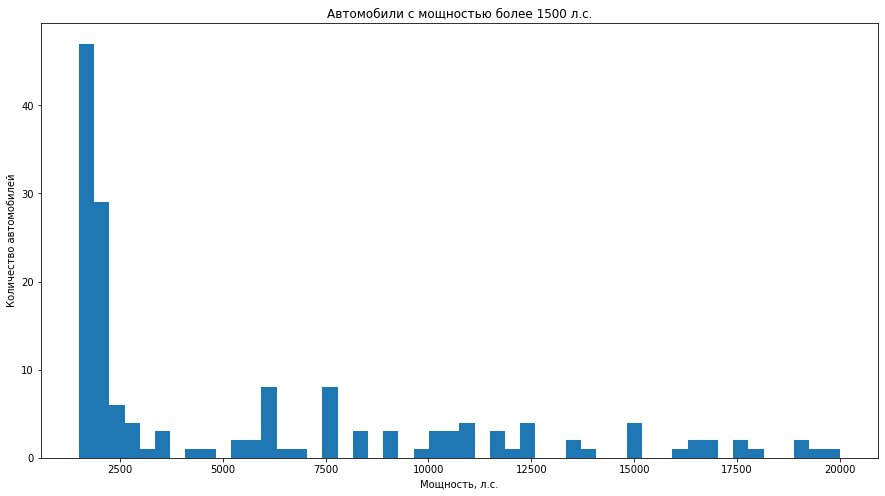

model
unk            17
golf            8
passat          6
3er             6
5er             6
corsa           6
other           6
e_klasse        5
polo            5
a4              5
vectra          5
c_klasse        5
astra           4
focus           4
cooper          3
transporter     3
laguna          3
zafira          3
a6              3
agila           2
80              2
clio            2
a3              2
tt              2
berlingo        2
fortwo          2
scenic          2
stilo           2
kangoo          2
spark           1
punto           1
rav             1
s_klasse        1
seicento        1
caddy           1
sprinter        1
tiguan          1
a8              1
touareg         1
up              1
toledo          1
omega           1
a_klasse        1
carisma         1
ceed            1
clk             1
c_max           1
c5              1
bravo           1
fiesta          1
galaxy          1
1er             1
ibiza           1
aygo            1
lupo            1
mega

In [ ]:
# построим гистограмму с распределением автомобилей мощностью более 1500 л.с.
data['power'].plot(kind='hist',
                   range=(1500,20000),
                   bins = 50,
                   figsize=(15,8))
plt.title('Автомобили с мощностью более 1500 л.с.')
plt.xlabel('Мощность, л.с.')
plt.ylabel('Количество автомобилей')
plt.show()

# выведем модели автомобилей
display(data.query('power>1500').value_counts(subset='model'))

Среди представленных моделей нет ни одного гиперкара, скорее всего пользователь ошибся с нулями. Удалим вбросы:

In [ ]:
data = data.query('power<1500')
print('Наибольшая мощность автомобиля в выборке составляет, л.с.:',data['power'].max())

Наибольшая мощность автомобиля в выборке составляет, л.с.: 1436


Спорткаров на рынке должно быть не очень много, посмотрим на 99-й перцентиль нашей выборки:

In [ ]:
print('99-й перцентиль равен, л.с.:',np.percentile (data.power, 99))

99-й перцентиль равен, л.с.: 306.0


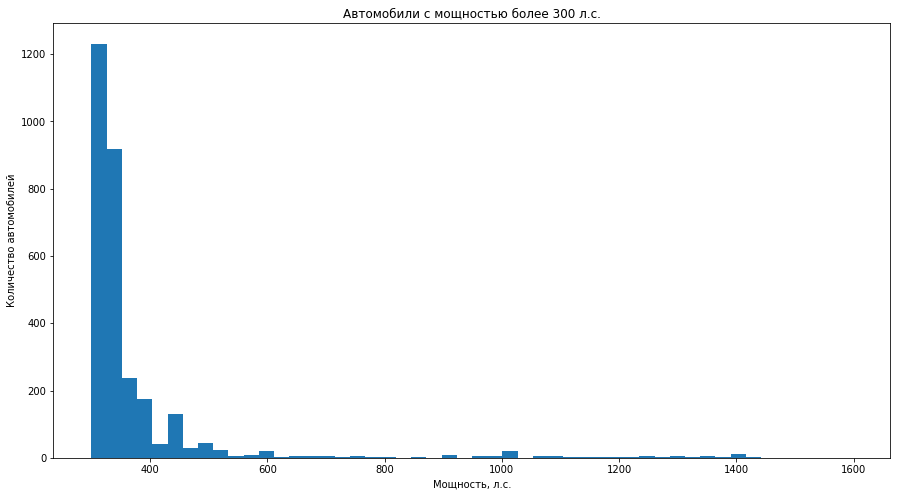

In [ ]:
# построим гистограмму с распределением автомобилей мощностью более 300 л.с.
data['power'].plot(kind='hist',
                   bins = 50,
                   range=(300,1598),
                   figsize=(15,8))
plt.title('Автомобили с мощностью более 300 л.с.')
plt.xlabel('Мощность, л.с.')
plt.ylabel('Количество автомобилей')
plt.show()

In [ ]:
# выведем модели автомобилей
display(data.query('power>600').value_counts(subset='model'))

model
unk            15
other          10
golf            7
corsa           6
polo            6
astra           4
3er             4
passat          4
e_klasse        3
ka              3
a_klasse        3
500             3
3_reihe         3
touran          2
scenic          2
punto           2
transporter     2
twingo          2
v40             2
micra           2
matiz           2
lupo            2
galaxy          2
zafira          2
focus           2
civic           2
c_klasse        2
c2              2
forfour         1
berlingo        1
ypsilon         1
yaris           1
x_trail         1
vectra          1
6_reihe         1
80              1
a3              1
a4              1
arosa           1
sharan          1
c4              1
rio             1
fortwo          1
outlander       1
colt            1
corolla         1
fabia           1
leon            1
kangoo          1
kaefer          1
fiesta          1
2_reihe         1
1er             1
dtype: int64

Вновь ни одного спорткара, ограничим выборку 600-ми л.с.:

In [ ]:
data = data.query('power<600')

Посмотрим на общее распределение мощностей очищенной выборки

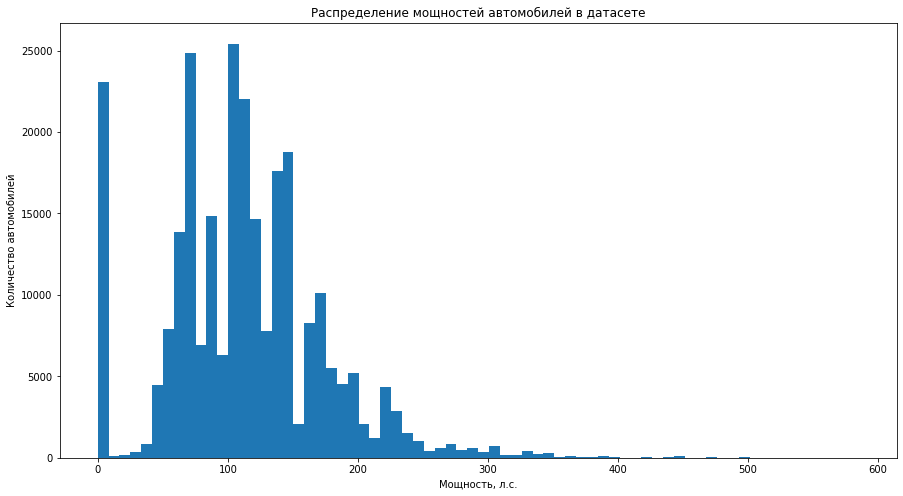

In [ ]:
data['power'].plot(kind='hist',
                   bins = 70,
                   figsize=(15,8))
plt.title('Распределение мощностей автомобилей в датасете')
plt.xlabel('Мощность, л.с.')
plt.ylabel('Количество автомобилей')
plt.show()

In [ ]:
power_0 = (data['power'] == 0).sum()/len(data)*100
print(f'Доля автомоблей с мощностью равной 0,%: {power_0.round(1)}')

Доля автомоблей с мощностью равной 0,%: 8.6


Доля вбросов достаточно большая, некачественные данные могут привести к некорректному обучению модели и исказить оценку результата алгоритма, удалим наблюдения с аномалиями:

In [ ]:
data = data.query('power!=0')

Проверим также автомобили с подозрительно малой мощностью:

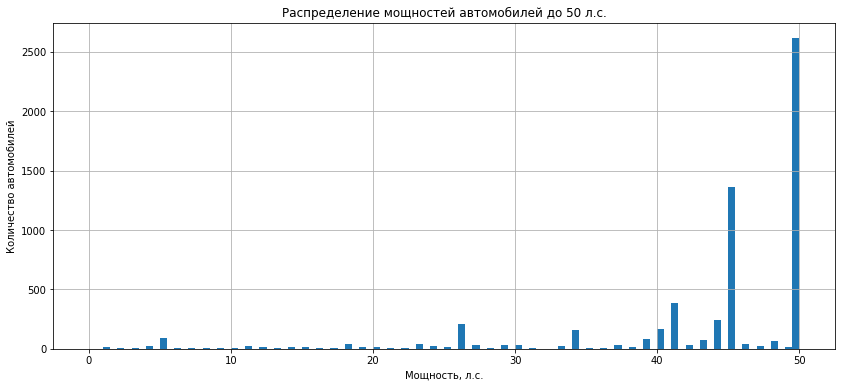

In [ ]:
data['power'].hist(range=(0,50),figsize=(14,6),bins=100)
plt.title('Распределение мощностей автомобилей до 50 л.с.')
plt.xlabel('Мощность, л.с.')
plt.ylabel('Количество автомобилей');

In [ ]:
print('1-й перцентиль равен, л.с.:',np.percentile (data.power, 1))

1-й перцентиль равен, л.с.: 45.0


Ограничим выборку 1-м перцентилем:

In [ ]:
data = data.query('power>=45')
data['power'].describe()

count    239857.000000
mean        124.729989
std          53.671678
min          45.000000
25%          86.000000
50%         116.000000
75%         150.000000
max         585.000000
Name: power, dtype: float64

#### Пробег

Проверим столбец `kilometer` на аномальные значения:

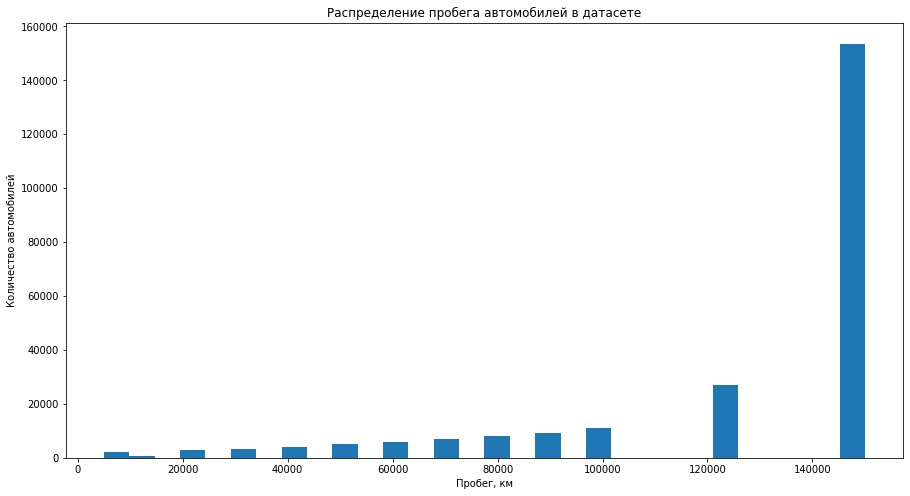

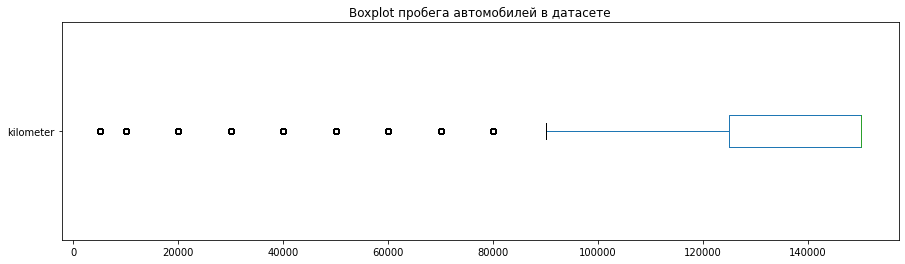

In [ ]:
data['kilometer'].plot(kind='hist',
                       bins=30,
                       figsize=(15,8))
plt.title('Распределение пробега автомобилей в датасете')
plt.xlabel('Пробег, км')
plt.ylabel('Количество автомобилей')
plt.show()

data['kilometer'].plot(kind='box',
                       vert=False,
                       figsize=(15,4))
plt.title('Boxplot пробега автомобилей в датасете')
plt.show()

В данных наблюдается незначительное количество выбросов, которое не является критичным. Пробег подержанных автомобилей может быть и небольшим. Оставим данные как есть.

### Корреляция

Посмотрим на взаимосвязь признаков датасета. Будем использовать библиотеку **phik** для анализа корреляции, так как данные содержат не только дискретные признаки, но также и категориальные, которые нельзя оценить корреляцией Пирсона (без предварительного кодирования).

<AxesSubplot:>

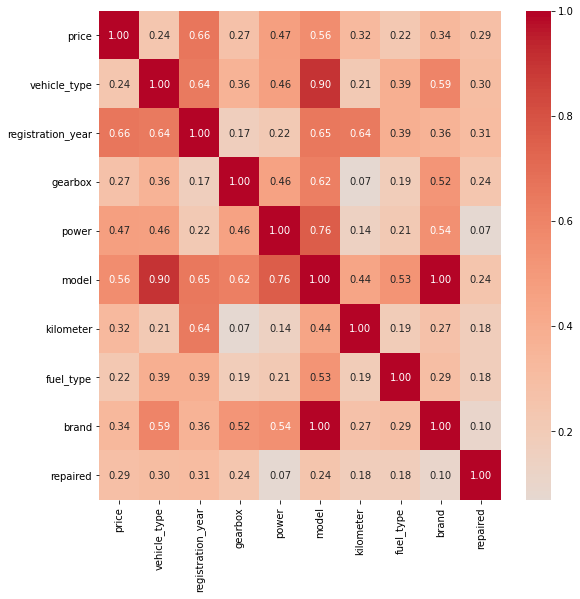

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(data.phik_matrix(interval_cols=['price','power']),
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt='.2f')

Целевой признак (цена) имеет наибольшую связь с моделью, годом регистрации и мощностью. Также можно заметить наличие мультиколлинеарности признаков (что вполне логично): модели и бренда, мощности, типа кузова, коробки передач, года регистрации; километража и года регистрации; года регистрации и типа кузова (коэффициент >0.6). При обучении моделей необходима регуляризация.

### Вывод

Выведем общую информацию об измененном датасете:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239857 entries, 1 to 309328
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              239857 non-null  int64 
 1   vehicle_type       239857 non-null  object
 2   registration_year  239857 non-null  int64 
 3   gearbox            239857 non-null  object
 4   power              239857 non-null  int64 
 5   model              239857 non-null  object
 6   kilometer          239857 non-null  int64 
 7   fuel_type          239857 non-null  object
 8   brand              239857 non-null  object
 9   repaired           239857 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.1+ MB

Было удалено 32.3% данных.


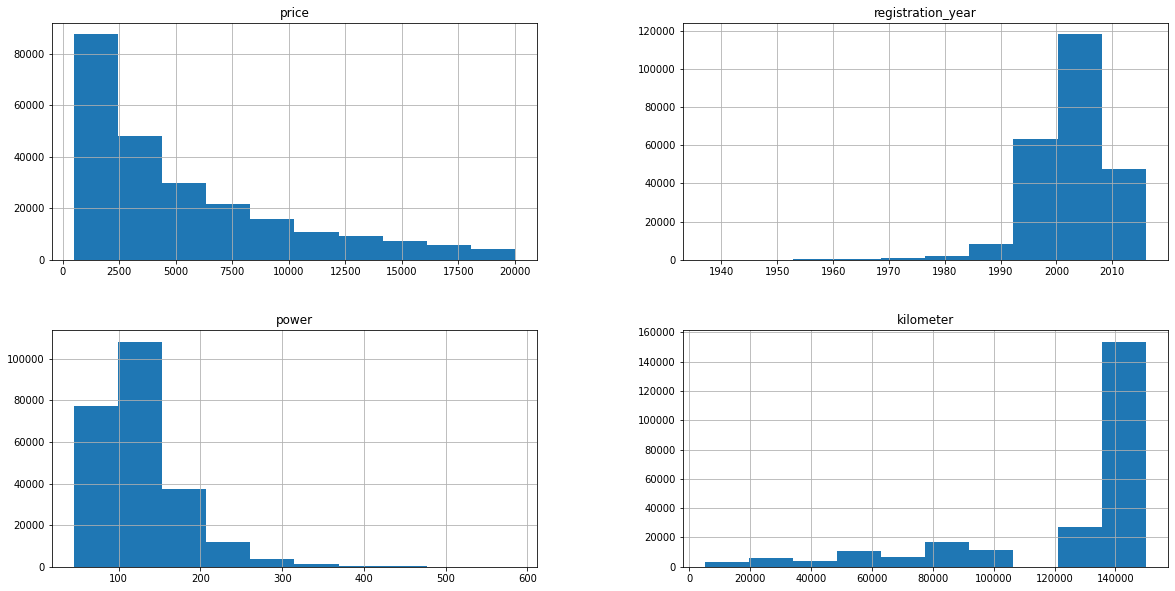

In [ ]:
data.info()

print('')

print(f'Было удалено {round((len(df) - len(data))/len(df)*100,1)}% данных.')

data.hist(figsize=(20,10));

Заменим тип float на int в столбце `power`:

In [ ]:
data['power']=data['power'].astype(int)
data.power.dtype

dtype('int64')

**Итог:**

На этапе предобработки данных нами были сделаны следующие преобразования:

- удалены из датасета неинформативные признаки;
- пропуски в категориальных признаках заменены на "unk";
- удалены явные дубликаты (13% данных);
- удалены аномальные значений параметров (19% данных).

## Подготовка выборок

Разобьем данные на 3 выборки в соотношении 60/20/20, предварительно отделив целевой признак. 60% данных оставим для тренировочной выборки, по 20% данных - для валидационной и тестовой выборок:

In [ ]:
features = data.drop(['price'], axis = 1)
target = data['price']

In [ ]:
features_train, features_remains, target_train, target_remains = train_test_split(features,
                                                                                  target,
                                                                                  test_size=0.4,
                                                                                  random_state=123)

features_valid, features_test, target_valid, target_test = train_test_split(features_remains,
                                                                            target_remains,
                                                                            test_size=0.5,
                                                                            random_state=123)

print('Количество данных в целевом признаке:')
print(target_train.shape,
      target_valid.shape,
      target_test.shape)
print('Количество данных в предикторах:')
print(features_train.shape,
      features_valid.shape,
      features_test.shape)

Количество данных в целевом признаке:
(143914,) (47971,) (47972,)
Количество данных в предикторах:
(143914, 9) (47971, 9) (47972, 9)


Для обучения линейной регрессии подготовим выборки отдельно - категориальные признаки закодируем, а числовые стандартизируем. Для градиентного бустинга в этом нет необходимости, модели могут работать с категориальными данными из коробки.

### Подготовка выборок для моделей линейной регрессии

Столбцы `kilometer` и `registration_year` имеют распределение категориального признака, будем работать с ними как с категориями. Изменим тип данных на object:

In [ ]:
cats = ['registration_year','kilometer']
data[cats] = features_train[cats].astype('object')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239857 entries, 1 to 309328
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              239857 non-null  int64 
 1   vehicle_type       239857 non-null  object
 2   registration_year  143914 non-null  object
 3   gearbox            239857 non-null  object
 4   power              239857 non-null  int64 
 5   model              239857 non-null  object
 6   kilometer          143914 non-null  object
 7   fuel_type          239857 non-null  object
 8   brand              239857 non-null  object
 9   repaired           239857 non-null  object
dtypes: int64(2), object(8)
memory usage: 20.1+ MB


Используем **StandardScaler** для того, чтобы стандартизировать числовые признаки,
категориальные данные закодируем с помощью **OneHotEncoder**, так как он наиболее универсален:

In [ ]:
column_transformer = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include='number')),
    (OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
     make_column_selector(dtype_exclude='number')),
    remainder='passthrough'
)
column_transformer.fit(features_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f7082722460>),
                                ('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f7082722b80>)])

In [ ]:
features_train_reg = column_transformer.transform(features_train)
features_valid_reg = column_transformer.transform(features_valid)
features_test_reg = column_transformer.transform(features_test)

### Подготовка выборок для градиентного бустинга

Для градиентного бустинга переведем категориальные данные из типа object  в тип category:

In [ ]:
cat_features = data.select_dtypes(include='object').columns.tolist()
features_train = features_train.copy()
features_valid = features_valid.copy()
features_test = features_test.copy()
features_train[cat_features] = features_train[cat_features].astype('category')
features_valid[cat_features] = features_valid[cat_features].astype('category')
features_test[cat_features] = features_test[cat_features].astype('category')

## Обучение моделей

### Линейная регрессия

Протестируем 3 модели линейной регрессии с регуляризацией без настройки гиперпараметров:

In [ ]:
def RegressionModelTraining(x_train, y_train, x_valid, y_valid) :
    model_dict = {
        "Ridge": Ridge(random_state = 123),
        "Lasso": Lasso(random_state = 123),
        "ElasticNet": ElasticNet(random_state = 123)
    }

    for model_name, model in model_dict.items() :
        model.fit(x_train, y_train)
        preds = model.predict(x_valid)
        RMSE = mean_squared_error(y_valid, preds, squared=False)
        print(model_name,'|',"RMSE =", RMSE.round(3))

In [ ]:
RegressionModelTraining(features_train_reg, target_train, features_valid_reg, target_valid)

Ridge | RMSE = 2624.69
Lasso | RMSE = 2656.542
ElasticNet | RMSE = 3213.907


Лучший результат показала Ridge-регрессия, попробуем подобрать оптимальное значение альфа:

In [ ]:
best_model_ridge = None
best_result = 3000
alpha_list = [1e-2, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1, 2, 4, 7, 10, 20, 30, 55, 100]

for alpha in alpha_list:
    model = Ridge(alpha=alpha, random_state=123)
    model.fit(features_train_reg, target_train)
    predictions = model.predict(features_valid_reg)
    result = mean_squared_error(target_valid, predictions, squared=False)

    if result < best_result:
        best_model_ridge = model
        best_result_ridge = result
        best_alpha = alpha

print("Оптимальное значение alpha:",best_alpha)
print("RMSE Ridge-регреcсии на валидационной выборке:", best_result_ridge)

Оптимальное значение alpha: 100
RMSE Ridge-регреcсии на валидационной выборке: 2651.8360553159323


Измерим время обучения и предсказания Ridge-регреcсии с подобранным alpha на валидационной выборке:

In [ ]:
start_time_train = time.time()
best_model_ridge.fit(features_train_reg, target_train)
end_time_train = time.time()

start_time_pred = time.time()
predictions = best_model_ridge.predict(features_valid_reg)
end_time_pred = time.time()

train_time_ridge = round(end_time_train - start_time_train,2)
pred_time_ridge = round(end_time_pred - start_time_pred,2)

print(f"Время обучения Ridge-регреcсии: {train_time_ridge} с")
print(f"Время предсказания Ridge-регреcсии: {pred_time_ridge} с")

Время обучения Ridge-регреcсии: 1.89 с
Время предсказания Ridge-регреcсии: 0.2 с


Значение RMSE Ridge-регреcсии на валидационной выборке выше порогового, при этом обучается и предсказывает модель довольно быстро.

Создадим сравнительную таблицу, чтобы результаты моделей было проще анализировать:

In [ ]:
table = pd.DataFrame(columns=['Модель', 'Время обучения,c', 'Время предсказания,c', 'RMSE'])
table.loc[0] = ['Ridge-регреcсия', train_time_ridge, pred_time_ridge, best_result_ridge]
display(table)

,Модель,"Время обучения,c","Время предсказания,c",RMSE
0,Ridge-регреcсия,1.89,0.2,2651.836055


### LightGBM

Следующая модель для теста - LightGBM. Для подбора гиперпараметров будем использовать **Optuna**:

In [ ]:
# создадим датасеты для обучения и поиска гиперепараметров
train_lgbr = lgb.Dataset(features_train, label = target_train, categorical_feature = None)
valid_lgbr = lgb.Dataset(features_valid, label = target_valid, categorical_feature = None)

In [ ]:
# определяем целевую функцию objective
def objective(trial):

    # словарь с параметрами
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'random_state': 123,
        'max_depth': trial.suggest_categorical('max_depth', [10,20,30]),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.01,0.014,0.02]),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 256)
    }

    # настраиваем интервал логов
    callbacks = [lgb.callback.log_evaluation(period=100)]

    model = lgb.train(params,train_lgbr,valid_sets=[valid_lgbr], categorical_feature = cat_features,
                      callbacks=callbacks, num_boost_round = 500)

    preds = model.predict(features_valid)

    rmse = mean_squared_error(target_valid, preds, squared=False)

    return rmse

In [ ]:
# создаем объект обучения с помощью метода optuna.create_study
sampler = optuna.samplers.TPESampler(seed=123)
study = optuna.create_study(direction='minimize',sampler=sampler)

# запускаем оптимизацию целевой функции objective на 7 итераций
study.optimize(objective, n_trials=7)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

# сохраним лучшее значение метрики
rmse_lgbr = study.best_value
params_lgbr = study.best_params

[I 2023-11-03 13:38:18,626] A new study created in memory with name: no-name-c2e8f9db-a384-4888-a892-d8b8f08de4fd


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.305037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 143914, number of used features: 9


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 5261.364829
[100]	valid_0's rmse: 2107.33
[200]	valid_0's rmse: 1702.78
[300]	valid_0's rmse: 1632.19
[400]	valid_0's rmse: 1610.38
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's rmse: 1599.52


[I 2023-11-03 13:42:27,851] Trial 0 finished with value: 1599.5197590877121 and parameters: {'max_depth': 10, 'lambda_l2': 0.0009158680769923057, 'learning_rate': 0.014, 'num_leaves': 124}. Best is trial 0 with value: 1599.5197590877121.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 143914, number of used features: 9
[LightGBM] [Info] Start training from score 5261.364829
[100]	valid_0's rmse: 2204.01
[200]	valid_0's rmse: 1768.99
[300]	valid_0's rmse: 1677.19
[400]	valid_0's rmse: 1646.27
[500]	valid_0's rmse: 1631.68


[I 2023-11-03 13:43:03,039] Trial 1 finished with value: 1631.6779376092222 and parameters: {'max_depth': 30, 'lambda_l2': 8.854217827991292e-05, 'learning_rate': 0.014, 'num_leaves': 46}. Best is trial 0 with value: 1599.5197590877121.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 143914, number of used features: 9
[LightGBM] [Info] Start training from score 5261.364829
[100]	valid_0's rmse: 3058.19
[200]	valid_0's rmse: 2283.15
[300]	valid_0's rmse: 1929.65
[400]	valid_0's rmse: 1772.55
[500]	valid_0's rmse: 1701.1


[I 2023-11-03 13:43:57,324] Trial 2 finished with value: 1701.0980643846478 and parameters: {'max_depth': 30, 'lambda_l2': 0.44145470178120466, 'learning_rate': 0.006, 'num_leaves': 94}. Best is trial 0 with value: 1599.5197590877121.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 143914, number of used features: 9
[LightGBM] [Info] Start training from score 5261.364829
[100]	valid_0's rmse: 2142
[200]	valid_0's rmse: 1726.96
[300]	valid_0's rmse: 1648.52
[400]	valid_0's rmse: 1623.28
[500]	valid_0's rmse: 1610.8


[I 2023-11-03 13:44:47,679] Trial 3 finished with value: 1610.7964285955595 and parameters: {'max_depth': 30, 'lambda_l2': 6.74441770040486e-08, 'learning_rate': 0.014, 'num_leaves': 81}. Best is trial 0 with value: 1599.5197590877121.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 143914, number of used features: 9
[LightGBM] [Info] Start training from score 5261.364829
[100]	valid_0's rmse: 3011.7
[200]	valid_0's rmse: 2223.05
[300]	valid_0's rmse: 1875.17
[400]	valid_0's rmse: 1726.93
[500]	valid_0's rmse: 1662.29


[I 2023-11-03 13:46:28,855] Trial 4 finished with value: 1662.2876105032049 and parameters: {'max_depth': 30, 'lambda_l2': 0.0003284959979640214, 'learning_rate': 0.006, 'num_leaves': 222}. Best is trial 0 with value: 1599.5197590877121.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 143914, number of used features: 9
[LightGBM] [Info] Start training from score 5261.364829
[100]	valid_0's rmse: 2098.75
[200]	valid_0's rmse: 1696.52
[300]	valid_0's rmse: 1626.37
[400]	valid_0's rmse: 1603.83
[500]	valid_0's rmse: 1592.22


[I 2023-11-03 13:47:37,251] Trial 5 finished with value: 1592.2249992105349 and parameters: {'max_depth': 30, 'lambda_l2': 0.00047355025339602757, 'learning_rate': 0.014, 'num_leaves': 140}. Best is trial 5 with value: 1592.2249992105349.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 143914, number of used features: 9
[LightGBM] [Info] Start training from score 5261.364829
[100]	valid_0's rmse: 3027.33
[200]	valid_0's rmse: 2242.18
[300]	valid_0's rmse: 1892.71
[400]	valid_0's rmse: 1740.89
[500]	valid_0's rmse: 1673.92


[I 2023-11-03 13:48:56,680] Trial 6 finished with value: 1673.9187687017727 and parameters: {'max_depth': 30, 'lambda_l2': 0.013542750957297749, 'learning_rate': 0.006, 'num_leaves': 161}. Best is trial 5 with value: 1592.2249992105349.


Best hyperparameters: {'max_depth': 30, 'lambda_l2': 0.00047355025339602757, 'learning_rate': 0.014, 'num_leaves': 140}
Best RMSE: 1592.2249992105349


Замерим время обучения LGBMRegressor с оптимальными параметрами:

In [ ]:
start_time = time.time()
lgbr = lgb.train(params_lgbr,train_lgbr, num_boost_round = 500, categorical_feature = cat_features)
end_time = time.time()
train_time_lgbr = round(end_time - start_time, 2)
print(f"Время обучения LGBMRegressor: {train_time_lgbr} с")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 143914, number of used features: 9
[LightGBM] [Info] Start training from score 5261.364829
Время обучения LGBMRegressor: 55.5 с


Замерим время предсказания:

In [ ]:
start_time = time.time()
preds_lgbr = lgbr.predict(features_valid)
end_time = time.time()
pred_time_lgbr = round(end_time - start_time,2)
print(f"Время предсказания LGBMRegressor: {pred_time_lgbr} секунд")

Время предсказания LGBMRegressor: 9.62 секунд


Обучается и предсказывает LGBMRegressor дольше Ridge-регрессии, а вот качество предсказаний значительно лучше. Метрика преодолела пороговое значение.

In [ ]:
table.loc[1] = ['LightGBM', train_time_lgbr, pred_time_lgbr, rmse_lgbr]

### CatBoost

Протестируем еще одну модель градиентого бустинга - CatBoost. Для подбора оптимальных гиперпараметров будем использовать **Optuna**. Область поиска гиперпараметров возьмем сравнимую с областью поиска для LGBMRegressor:

In [ ]:
# определяем целевую функцию objective
def objective(trial):

    # словарь параметров
    params = {
        'loss_function': 'RMSE',
        'random_state': 123,
        'n_estimators': 500,
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.01,0.014,0.02]),
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 1, 200),
        'max_depth':  trial.suggest_categorical('max_depth', [5,7,9,11,13,15])
    }

    model = cb.CatBoostRegressor(**params)
    model.fit(features_train,target_train, cat_features=cat_features,verbose=100)
    predictions = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, predictions, squared=False)
    return rmse

In [ ]:
# создаем объект обучения
study = optuna.create_study(direction='minimize', sampler=sampler)

# запускаем оптимизацию целевой функции objective на 7 итераций
study.optimize(objective, n_trials=7)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

# сохраним лучшее значение метрики и оптимальные параметры
rmse_cb = study.best_value
params_cb = study.best_params

[I 2023-11-03 13:50:01,976] A new study created in memory with name: no-name-63c6c700-743d-4a5d-bd4a-2fc968912a7d


0:	learn: 4637.1616949	total: 385ms	remaining: 3m 12s
100:	learn: 3143.0874794	total: 26.8s	remaining: 1m 45s
200:	learn: 2407.3416303	total: 53.9s	remaining: 1m 20s
300:	learn: 2056.5781249	total: 1m 21s	remaining: 53.9s
400:	learn: 1892.4049437	total: 1m 51s	remaining: 27.4s
499:	learn: 1808.5212531	total: 2m 19s	remaining: 0us


[I 2023-11-03 13:52:24,463] Trial 0 finished with value: 1845.3885636996506 and parameters: {'l2_leaf_reg': 0.011808682853587825, 'learning_rate': 0.006, 'min_data_in_leaf': 39, 'max_depth': 9}. Best is trial 0 with value: 1845.3885636996506.


0:	learn: 4586.6087667	total: 476ms	remaining: 3m 57s
100:	learn: 1899.7397821	total: 46.4s	remaining: 3m 3s
200:	learn: 1646.6857186	total: 1m 40s	remaining: 2m 29s
300:	learn: 1572.9883400	total: 2m 35s	remaining: 1m 42s
400:	learn: 1528.2030024	total: 3m 30s	remaining: 52.1s
499:	learn: 1491.5702723	total: 4m 26s	remaining: 0us


[I 2023-11-03 13:56:53,411] Trial 1 finished with value: 1637.2808463148267 and parameters: {'l2_leaf_reg': 0.002238138278733199, 'learning_rate': 0.02, 'min_data_in_leaf': 64, 'max_depth': 11}. Best is trial 1 with value: 1637.2808463148267.


0:	learn: 4596.6039380	total: 148ms	remaining: 1m 13s
100:	learn: 2220.4893151	total: 12.2s	remaining: 48.1s
200:	learn: 1921.7204436	total: 25s	remaining: 37.2s
300:	learn: 1846.8623967	total: 37.9s	remaining: 25.1s
400:	learn: 1804.6134119	total: 50.8s	remaining: 12.5s
499:	learn: 1776.8450174	total: 1m 4s	remaining: 0us


[I 2023-11-03 13:57:59,386] Trial 2 finished with value: 1793.7052650961477 and parameters: {'l2_leaf_reg': 2.4678750890085655e-08, 'learning_rate': 0.02, 'min_data_in_leaf': 72, 'max_depth': 5}. Best is trial 1 with value: 1637.2808463148267.


0:	learn: 4622.0435409	total: 517ms	remaining: 4m 18s
100:	learn: 2518.9725846	total: 44.5s	remaining: 2m 55s
200:	learn: 1896.8995449	total: 1m 33s	remaining: 2m 19s
300:	learn: 1716.7244505	total: 2m 28s	remaining: 1m 37s
400:	learn: 1645.1069339	total: 3m 22s	remaining: 49.9s
499:	learn: 1602.9944061	total: 4m 19s	remaining: 0us


[I 2023-11-03 14:02:22,917] Trial 3 finished with value: 1695.463643917673 and parameters: {'l2_leaf_reg': 1.2334005178604222e-05, 'learning_rate': 0.01, 'min_data_in_leaf': 65, 'max_depth': 11}. Best is trial 1 with value: 1637.2808463148267.


0:	learn: 4623.5775287	total: 303ms	remaining: 2m 31s
100:	learn: 2594.2331435	total: 27.4s	remaining: 1m 48s
200:	learn: 1986.7244155	total: 55.8s	remaining: 1m 22s
300:	learn: 1805.7955042	total: 1m 26s	remaining: 57.2s
400:	learn: 1737.8780675	total: 1m 56s	remaining: 28.8s
499:	learn: 1699.1455842	total: 2m 27s	remaining: 0us


[I 2023-11-03 14:04:54,567] Trial 4 finished with value: 1745.377774519293 and parameters: {'l2_leaf_reg': 1.543057395363807e-05, 'learning_rate': 0.01, 'min_data_in_leaf': 116, 'max_depth': 9}. Best is trial 1 with value: 1637.2808463148267.


0:	learn: 4620.7819224	total: 1.93s	remaining: 16m 3s
100:	learn: 2397.2576035	total: 3m 4s	remaining: 12m 8s
200:	learn: 1711.9378433	total: 6m 23s	remaining: 9m 30s
300:	learn: 1507.6702018	total: 10m	remaining: 6m 36s
400:	learn: 1421.7581829	total: 13m 44s	remaining: 3m 23s
499:	learn: 1369.6168555	total: 17m 42s	remaining: 0us


[I 2023-11-03 14:22:41,558] Trial 5 finished with value: 1634.6270685840204 and parameters: {'l2_leaf_reg': 0.00047873080899639013, 'learning_rate': 0.01, 'min_data_in_leaf': 162, 'max_depth': 15}. Best is trial 5 with value: 1634.6270685840204.


0:	learn: 4593.1798351	total: 196ms	remaining: 1m 37s
100:	learn: 2085.1527331	total: 18.9s	remaining: 1m 14s
200:	learn: 1826.9008954	total: 38.6s	remaining: 57.5s
300:	learn: 1759.0449507	total: 58.5s	remaining: 38.7s
400:	learn: 1720.6489998	total: 1m 18s	remaining: 19.5s
499:	learn: 1694.6000551	total: 1m 39s	remaining: 0us


[I 2023-11-03 14:24:23,634] Trial 6 finished with value: 1724.4038088239786 and parameters: {'l2_leaf_reg': 5.179550996815396e-08, 'learning_rate': 0.02, 'min_data_in_leaf': 19, 'max_depth': 7}. Best is trial 5 with value: 1634.6270685840204.


Best hyperparameters: {'l2_leaf_reg': 0.00047873080899639013, 'learning_rate': 0.01, 'min_data_in_leaf': 162, 'max_depth': 15}
Best RMSE: 1634.6270685840204


Измерим время обучения CatBoostRegressor с оптимальными параметрами:

In [ ]:
start_time = time.time()
catboost = cb.CatBoostRegressor(**params_cb, n_estimators = 500, cat_features=cat_features,
                                random_state = 123, verbose=100)
catboost = catboost.fit(features_train,target_train)
end_time = time.time()

train_time_cb = round(end_time - start_time,2)
print(f"Время обучения CatBoost: {train_time_cb} секунд")

0:	learn: 4620.7819224	total: 1.94s	remaining: 16m 8s
100:	learn: 2397.2576035	total: 3m 5s	remaining: 12m 12s
200:	learn: 1711.9378433	total: 6m 22s	remaining: 9m 29s
300:	learn: 1507.6702018	total: 9m 56s	remaining: 6m 34s
400:	learn: 1421.7581829	total: 13m 41s	remaining: 3m 22s
499:	learn: 1369.6168555	total: 17m 37s	remaining: 0us
Время обучения CatBoost: 1061.64 секунд


Обучается модель достаточно долго. Измерим время предсказания CatBoost:

In [ ]:
start_time = time.time()
preds_cb = catboost.predict(features_valid)
end_time = time.time()

pred_time_cb = round(end_time - start_time,2)
print(f"Время предсказания CatBoostRegressor: {pred_time_cb} секунд")

Время предсказания CatBoostRegressor: 0.69 секунд


Модель показала неплохой результат в сравнении с линейными моделями, значение метрики ниже порогового.

In [ ]:
table.loc[2] = ['CatBoost', train_time_cb, pred_time_cb, rmse_cb]

## Анализ моделей

### Проверка на адекватность

Используем DummyRegressor, который всегда предсказывает медиану, для проверки моделей на адекватность:

In [ ]:
dummy_reg = DummyRegressor(strategy = 'median').fit(features_train, target_train)
dummy_preds = dummy_reg.predict(features_test)
print("RMSE DummyRegressor:", mean_squared_error(target_test,dummy_preds,squared=False))

RMSE DummyRegressor: 4940.719934173524


Все модели проходят проверку на адекватность.

### Анализ важности признаков

Сравним важность признаков для моделей градиентного бустинга:

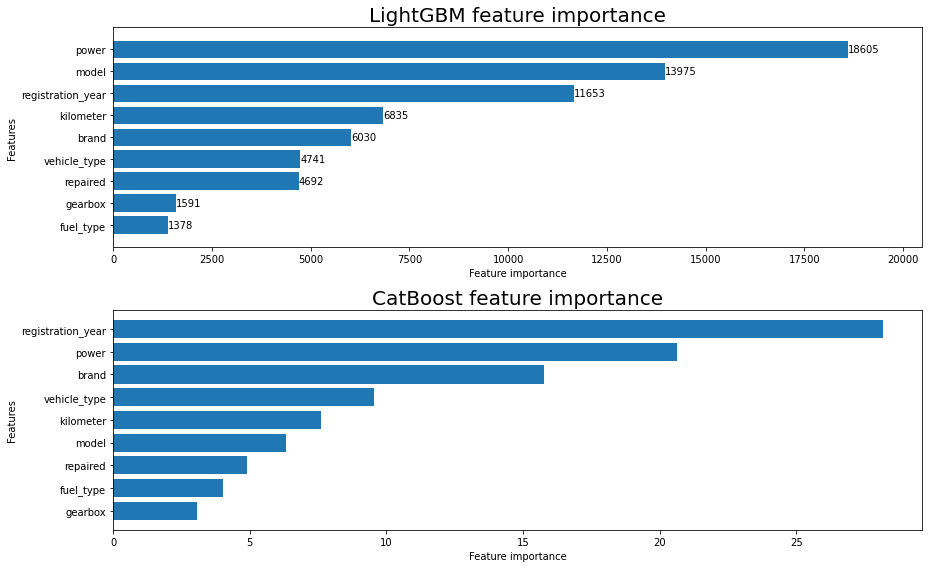

In [ ]:
# построим 2 барплота для lightgbm и catboost
fig, axs = plt.subplots(2, 1, figsize=(13, 8))

lgb.plot_importance(lgbr, ax=axs[0], height=0.8, grid=False)
axs[0].set_title('LightGBM feature importance',size=20)

importances = catboost.get_feature_importance()
feature_importance_cb = pd.Series(importances, index=features_train.columns).sort_values()
axs[1].barh(feature_importance_cb.index, feature_importance_cb.values)
axs[1].set_title('CatBoost feature importance',size=20)
axs[1].set_xlabel('Feature importance')
axs[1].set_ylabel('Features')

plt.tight_layout()
plt.show()

Для LGBMRegressor наиболее важными признаками являются мощность, год регистрации и модель, наименее значимы - тип топлива, коробка передач и тип кузова.

Важность признаков у CatBoostRegressor схожа, но есть и заметные отличия. Год регистрации и мощность занимают 1 и 2 место соответственно, а на третьем распологается бренд. В отличие от LGBMR, тип кузова оказывает большее влияние на формирование цены.

### Выбор лучшей модели

Выведем таблицу для сравнения ключевых показателей моделей:

In [ ]:
display(table)

,Модель,"Время обучения,c","Время предсказания,c",RMSE
0,Ridge-регреcсия,1.89,0.20,2651.836055
1,LightGBM,55.50,9.62,1592.224999
2,CatBoost,1061.64,0.69,1634.627069


Наша задача состояла в том, чтобы построить модель, которая умеет определять цену автомобиля по его техническим характеристикам и комплектации. Для заказчика были важны следующие критерии:

- качество предсказания (пороговое значение метрики RMSE = 2500);
- время обучения модели;
- время предсказания модели.

Среди линейных моделей лучший результат показала Ridge-регрессия, однако, она не преодолела порогового значения точности результата. Время обучения и время предсказания у нее самые быстрые.

Фреймворк LightGBM показал лучшую точность среди сравниваемых моделей и относительно недолгое время обучения (модель обучается в 19 раз быстрее CatBoost).

Модель на основе CatBoost достигла неплохого качества на валидационной выборке, а время предсказания у нее сравнимо с Ridge-регреcсией и составляет менее 1 с.

Таким образом, по совокупности параметров оптимальной моделью для заказчика выглядит **LightGBM**. Проверим ее на тестовой выборке:

In [ ]:
preds_lgbr = lgbr.predict(features_test)
rmse_lgbr_test = mean_squared_error(target_test, preds_lgbr, squared=False)
print('RMSE LightGBM на тестовой выборке:', round(rmse_lgbr_test,2))

RMSE LightGBM на тестовой выборке: 1587.89


На тестовой выборке модель LightGBM также показала себя хорошо, значение метрики незначительно улучшилось по сравнению с валидационной выборкой.

**В таком случае заказчику можно рекомендовать модель на основе LightGBM.**